## FnSpace 활용사례 - Monte-Carlo Simulation을 활용한 KOSPI200 예측

In [3]:
! pip install fnspace exchange_calendars

In [4]:
import numpy as np
import pandas as pd
import scipy.optimize as sco
import requests 
import time
from fnspace import FnSpace

api_key = 'Your API Key'
fs = FnSpace(api_key)

## 데이터 로드 및 정렬

In [5]:
## KOSPI200 지표 추종 ETF인 KODEX 200 검색
df = fs.get_data(category='stock_list',mkttype='1')
filtered_df = df[df['ITEM_NM'].str.contains("KODEX")] # KODEX 200 : A069500
filtered_df

,ITEM_CD,P_ITEM_CD,ITEM_NM,MKT_TYP,MKT_NM,KOSDAQ150_YN,SEC_CD,SEC_CD_NM,SEC_CD_DET,SEC_CD_DET_NM,FINACC_TYP,BASE_IDX_NM_KOR,ETF_TYP_SVC_NM
1489,A481050,KOSPI,KODEX 1년은행양도성예금증서+액티브(합성),1,KOSPI,0,None,None,IKS099,미분류,미분류,KAP 1년은행 CD+추가금리 지수(총수익지수),"국내채권형, 파생"
1490,A069500,KOSPI,KODEX 200,1,KOSPI,0,None,None,IKS099,미분류,미분류,코스피 200,"국내주식형, 대표지수"
1491,A226980,KOSPI,KODEX 200 중소형,1,KOSPI,0,None,None,IKS099,미분류,미분류,코스피 200 중소형주지수,"국내주식형, 대표지수"
1492,A223190,KOSPI,KODEX 200가치저변동,1,KOSPI,0,None,None,IKS099,미분류,미분류,코스피 200 가치저변동성,"국내주식형, 전략지수"
1493,A252650,KOSPI,KODEX 200동일가중,1,KOSPI,0,None,None,IKS099,미분류,미분류,코스피 200 동일가중지수,"국내주식형, 대표지수"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,A329650,KOSPI,KODEX TRF3070,1,KOSPI,0,None,None,IKS099,미분류,미분류,FnGuide TRF 3070 지수,"국내혼합형, 주식/채권"
1675,A329660,KOSPI,KODEX TRF5050,1,KOSPI,0,None,None,IKS099,미분류,미분류,FnGuide TRF 5050 지수,"국내혼합형, 주식/채권"
1676,A329670,KOSPI,KODEX TRF7030,1,KOSPI,0,None,None,IKS099,미분류,미분류,FnGuide TRF 7030 지수,"국내혼합형, 주식/채권"
1677,A261220,KOSPI,KODEX WTI원유선물(H),1,KOSPI,0,None,None,IKS099,미분류,미분류,S&P GSCI Crude Oil Index ER,해외상품


In [6]:
# 주가 데이터 로드
df = fs.get_data(category="stock_price", 
                 code=["069500"], # KODEX 200
                 item="S100300", # 수정종가만 load
                 from_date="20230101", 
                 to_date="20240701")

# 'DT' 컬럼 이름을 'Date'로 변경
df.rename(columns={'DT': 'Date', 'S100300': 'Price'}, inplace=True)

# CODE를 기준으로 피봇하여 새로운 데이터프레임 생성
data = df.pivot(index='Date', columns='CODE', values='Price')
data

CODE,A069500
Date,
2022-12-29,28544
2023-01-02,28375
2023-01-03,28375
2023-01-04,28973
2023-01-05,29205
...,...
2024-06-25,38050
2024-06-26,38365
2024-06-27,38320


### Geometric Brownian Motion (GBM)

본 포스팅에선 시뮬레이션을 위한 주가 모델로 GBM을 가정합니다. 

Geometric Brownian Motion (GBM)은 금융 시장에서 자산 가격의 시간에 따른 변화를 모델링하기 위해 널리 사용되는 수학적 모델입니다. 이 모델은 자산 가격의 로그가 정규분포를 따른다고 가정하며, 이는 자산 가격이 음수가 되지 않는다는 특성을 반영합니다.

#### GBM의 수학적 표현

GBM의 기본 형태는 다음과 같은 확률미분방정식(SDE)으로 주어집니다:

$$\ dS_t = \mu S_t dt + \sigma S_t dW_t \tag {1}$$

여기서:
- $S_t$는 시간 $t$에서의 자산 가격
- $\mu$는 자산의 평균 수익률(drift)
- $\sigma$는 자산의 변동성(volatility or diffusion)
- $dW_t$는 표준브라운 운동(또는 위너 프로세스)의 증분을 나타내며, 금융시장의 noise를 정규분포로 모델링한 형태임.

#### GBM의 해석적 해

GBM의 해석적 해를 구하면 아래 형태가 됩니다:

$$S_t = S_{t-1} e^{(\mu - \frac{1}{2} \sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z_t} \tag{2} $$

여기서 $Z_t$는 t시점에 $N(0, 1)$로 부터 샘플링된 noise.

아래는 위 식 (2)를 활용하여 20일 동안의 Monte-Carlo Simulation을 진행해 주가가 확률적으로 어떤 양상이 될지 살펴보는 예제입니다.

In [9]:
# 데이터 다시 로드
rtns = data.pct_change().dropna().values # 일일 수익률

mu = rtns.mean() * 252 # GBM 파라미터 mu 대안
sigma = rtns.std() * np.sqrt(252) # GBM 파라미터 sigma 대안

# 몬테카를로 시뮬레이션 설정
T = 20 / 252 # 20영업일
dt = 1 / 252 # 1영업일
N = 10000 # 시뮬레이션 횟수
S0 = data.iloc[-1].item() # 최종 종가를 초기 가격으로 세팅

# 시뮬레이션
times_future = np.arange(dt, T+dt, dt) * 252  # 미래 시간 배열
S = np.zeros((len(times_future) + 1, N))
S[0, :] = S0

for t in range(1, len(times_future)+1):
    Z = np.random.normal(size=N)
    S[t, :] = S[t-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

maximum_after_20 = np.max(S[-1,:])
minimum_after_20 = np.min(S[-1,:])

# 상승 확률 추정
num_increase = np.sum(S[-1, :] > S0)
increase_probability = num_increase / N

print(f"[시뮬레이션 수 : {N} | 상승 path 수 : {num_increase} | 20일 뒤 상승 확률: {increase_probability:.2%}]")
print(f"[시뮬레이션 최대값 : {int(maximum_after_20)} | 최소값 : {int(minimum_after_20)} | 중위수 : {int(minimum_after_20)}]")

[시뮬레이션 수 : 10000 | 상승 path 수 : 6371 | 20일 뒤 상승 확률: 63.71%]
[시뮬레이션 최대값 : 47046 | 최소값 : 32722 | 중위수 : 32722]


## 시각화

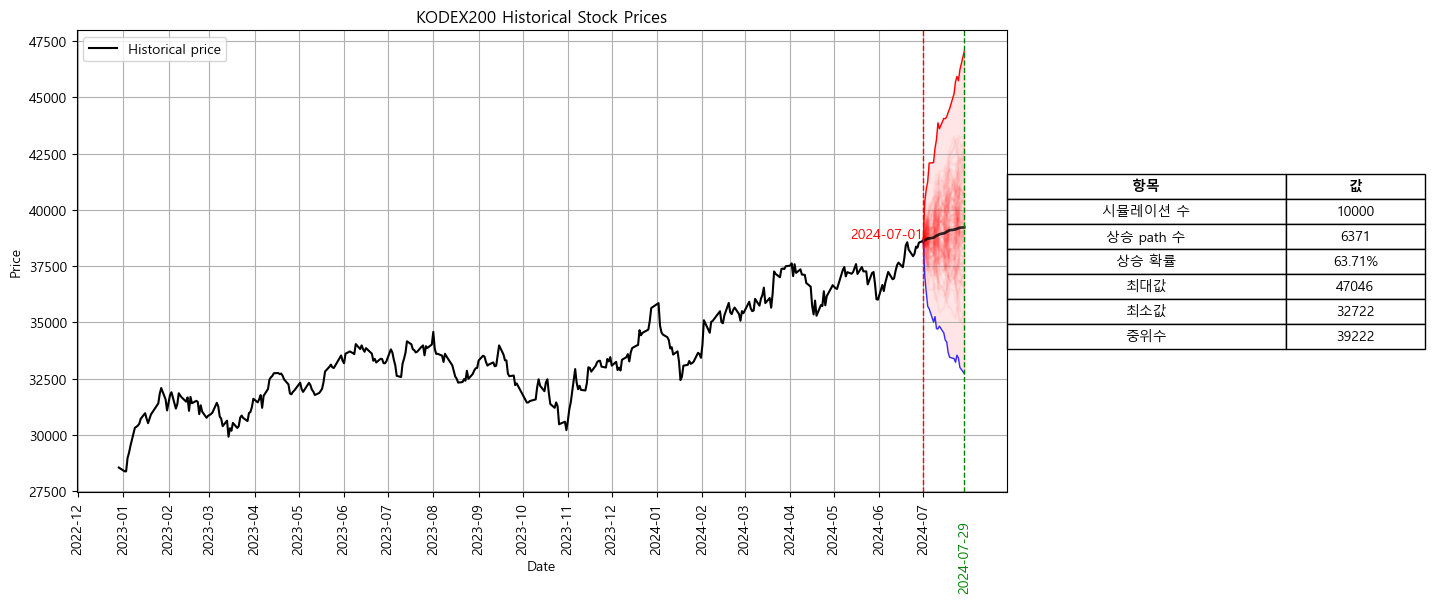

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import exchange_calendars as xcals

plt.rcParams['font.family'] = 'Malgun Gothic'  # 사용 가능한 한글 폰트로 변경

data.index = pd.to_datetime(data.index)  # 스트링 인덱스를 datetime 객체로 변환
xkrx = xcals.get_calendar("XKRX")
date_after20 = xkrx.sessions_window(data.index[-1], 21)

# 데이터 플로팅
plt.figure(figsize=(12, 6))
plt.plot(data.index, data.values, label='Historical price', color='black') 
# plt.plot(date_after20, S)

indices_to_show = np.random.choice(S.shape[1], 100, replace=False)
for path in S[:, indices_to_show].T:
    plt.plot(date_after20, path, 'r-', alpha=0.05)  # 붉은색 투명도로 모든 경로 표시

# 특별 경로 표시
plt.plot(date_after20, np.max(S, axis=1), 'red', linewidth=1)
plt.plot(date_after20, np.median(S, axis=1), 'black', alpha=0.8, linewidth=2)
plt.plot(date_after20, np.min(S, axis=1), 'blue', alpha=0.8, linewidth=1)

# 분산 영역 표시
plt.fill_between(date_after20, np.min(S, axis=1), np.max(S, axis=1), color='red', alpha=0.1)


# x축 포맷 설정
ax = plt.gca()  # 현재 axes를 가져옴
ax.xaxis.set_major_locator(mdates.MonthLocator())  # 매달을 주요 눈금으로 설정
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 년-월 형식으로 날짜 포맷

# 마지막 날짜에 대한 처리: 마지막 눈금 제거
xticks = ax.get_xticks()
if xticks[-1] > mdates.date2num(data.index[-1]):  # 마지막 눈금이 데이터의 마지막 인덱스보다 뒤에 있다면
    xticks = xticks[:-1]  # 마지막 눈금 제거
ax.set_xticks(xticks)

# x축 레이블을 90도 회전
plt.xticks(rotation=90)

# historical price 마지막 날짜에 붉은색 파선 추가
last_date = data.index[-1]
plt.axvline(x=last_date, color='red', linestyle='--', linewidth=1)

# historical price 마지막 날짜 옆에 텍스트 추가
plt.text(last_date, float(data.iloc[-1].item()), last_date.strftime('%Y-%m-%d'), color='red', verticalalignment='bottom', horizontalalignment='right')

# 마지막 시뮬레이션 날짜에 x축에 레이블 추가
simulation_end_date = date_after20[-1]
plt.axvline(x=simulation_end_date, color='green', linestyle='--', linewidth=1)  # 시뮬레이션 끝 지점 표시
ax.annotate(simulation_end_date.strftime('%Y-%m-%d'), xy=(simulation_end_date, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -20), textcoords='offset points', va='top', ha='center', rotation=90, color='green')

# 테이블 추가
table_data = [
    ["시뮬레이션 수", N],
    ["상승 path 수", num_increase],
    ["상승 확률", f"{increase_probability:.2%}"],
    ["최대값", f"{int(maximum_after_20)}"],
    ["최소값", f"{int(minimum_after_20)}"],
    ["중위수", f"{int(np.median(S[-1,:]))}"]
]
table = ax.table(cellText=table_data, colLabels=['항목', '값'], loc='right', cellLoc='center', colWidths=[0.2, 0.1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)  # 조정 필요에 따라 스케일 조정


# 테이블 헤더에 볼드체 적용
for (i, j), cell in table.get_celld().items():
    if i == 0:  # 첫 번째 행 선택
        cell.set_text_props(weight='bold')  # 텍스트 프로퍼티를 볼드로 설정

# 그래프 요소 추가
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('KODEX200 Historical Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

한편 본 포스팅에서 사용한 가격 시뮬레이션은 FnSpace의 아래 메서드 한 줄로 구현할 수도 있습니다.

In [ ]:
S = fs.simulation(price=data, model='GBM', T=20, n_sample=1000)

written by 장웅진